# Projeto Segmentação de Clientes de Food Delivery

In [1]:
# Importação de pacotes

# Manipulação e visualização de dados
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1, figsize = (15, 6))
%matplotlib inline

In [2]:
# Carrega o dataset
df_food_delivery = pd.read_csv("dados/dataset.csv", encoding = 'utf-8')

In [3]:
# Shape
df_food_delivery.shape

(260645, 7)

In [4]:
# Vizualização dos dados
df_food_delivery.head(10)

id_transacao       horario_pedido  localidade  nome_item  quantidade_item  \
0     0x7901ee  2019-01-16 18:33:00           7     bebida                2   
1     0x7901ee  2019-01-16 18:33:00           7      pizza                2   
2     0x7901ee  2019-01-16 18:33:00           7  sobremesa                2   
3     0x12b47f  2019-09-04 12:36:00           3     salada                1   
4     0x12b47f  2019-09-04 12:36:00           3  sobremesa                1   
5     0x6d6979  2019-03-18 00:27:00           6      pizza                2   
6     0x6d6979  2019-03-18 00:27:00           6  sobremesa                2   
7     0x78dd1e  2019-09-22 00:10:00           2     bebida                2   
8     0x78dd1e  2019-09-22 00:10:00           2      pizza                2   
9     0x78dd1e  2019-09-22 00:10:00           2  sobremesa                2   

    latitude  longitude  
0  41.794132 -88.010140  
1  41.794132 -88.010140  
2  41.794132 -88.010140  
3  41.884490 -87.627059  
4  41.884490 -87.627059  
5  41.784576 -87.607565  
6  41.784576 -87.607565  
7  42.049306 -87.677606  
8  42.049306 -87.677606  
9  42.049306 -87.677606

 ### Dicionário de Dados:

 - id_transacao: ID da transação. Um mesmo ID pode ter vários itens de um pedido.
 - localidade: Localidade que processou o pedido (unidade do restaurante).
 - nome_item: Nome do item (pizza, salada, bebida e sobremesa).
 - quantidade_item: Quantidade de itens no pedido.
 - latitude: Latitude da localidade onde o pedido foi gerado.
 - longitude: Longitude da localidade onde o pedido foi gerado.

### Análise Exploratória

In [5]:
# Verifica o total de valores únicos por coluna
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [6]:
# Tipos de Dados
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [7]:
# Resumo das colunas numéricas
df_food_delivery.describe()

localidade  quantidade_item       latitude      longitude
count  260645.000000    260645.000000  260645.000000  260645.000000
mean        5.134904         2.447010      41.836095     -87.733930
std         2.551846         1.330863       0.144459       0.136369
min         1.000000         1.000000      41.524598     -88.010140
25%         3.000000         1.000000      41.784576     -87.849468
50%         5.000000         2.000000      41.881818     -87.677606
75%         7.000000         4.000000      41.889047     -87.627059
max         9.000000         5.000000      42.049306     -87.607565

In [8]:
# Lista para receber o total de pedidos
total_pedidos = []

In [9]:
%%time

# tabela pivot
for k, group in df_food_delivery.groupby('id_transacao'):
    
    for m, n in group.groupby('horario_pedido'):
        
        id_transacao = k
        horario_pedido = m
        localidade = n['localidade'].values.tolist()[0]
        bebida = 0
        pizza = 0
        sobremesa = 0
        salada = 0
        n = n.reset_index(drop = True)
        
        for i in range(len(n)):
            item = n.loc[i, 'nome_item']
            num = n.loc[i, 'quantidade_item']
            
            if item == 'bebida':
                bebida = bebida + num
                
            elif item == 'pizza':
                pizza = pizza + num
                
            elif item == 'sobremesa':
                sobremesa = sobremesa + num
                
            elif item == 'salada':
                salada = salada + num
                
        output = [id_transacao, horario_pedido, localidade, bebida, pizza, sobremesa, salada]
        total_pedidos.append(output)    
     

Wall time: 3min 37s


In [10]:
df_item_pedidos = pd.DataFrame(total_pedidos)

In [11]:
df_item_pedidos.columns = ['id_transacao', 'horario_pedido', 'localidade', 'bebida', 'pizza', 'sobremesa', 'salada']

In [12]:
df_item_pedidos.shape

(100000, 7)

In [13]:
df_item_pedidos.nunique()

id_transacao      100000
horario_pedido     76799
localidade             9
bebida                 6
pizza                  6
sobremesa              5
salada                 6
dtype: int64

In [14]:
df_item_pedidos.head(3)

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0     0x10000a  2019-01-29 00:48:00           9       0      1          1   
1     0x100058  2019-05-05 00:08:00           6       0      2          2   
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5   

   salada  
0       0  
1       0  
2       1

In [15]:
df_item_pedidos.describe()

localidade         bebida          pizza      sobremesa  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        5.004700       1.239590       1.857840       2.569210   
std         2.544811       1.627886       1.588589       1.332084   
min         1.000000       0.000000       0.000000       1.000000   
25%         3.000000       0.000000       1.000000       1.000000   
50%         5.000000       0.000000       1.000000       2.000000   
75%         7.000000       3.000000       3.000000       4.000000   
max         9.000000       5.000000       5.000000       5.000000   

              salada  
count  100000.000000  
mean        0.711370  
std         1.086524  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         5.000000

In [16]:
df_item_pedidos.isnull().sum()

id_transacao      0
horario_pedido    0
localidade        0
bebida            0
pizza             0
sobremesa         0
salada            0
dtype: int64

### Granularidade do Tempo

In [17]:
df_item_pedidos['mes']= df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x, "%Y-%m-%d %H:%M:%S")))

In [18]:
df_item_pedidos.head(3)

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0     0x10000a  2019-01-29 00:48:00           9       0      1          1   
1     0x100058  2019-05-05 00:08:00           6       0      2          2   
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5   

   salada mes  
0       0  01  
1       0  05  
2       1  01

### Ajuste de Índice

In [19]:
df_item_pedidos_idx = df_item_pedidos.reset_index()

In [20]:
df_item_pedidos_idx.head()

index id_transacao       horario_pedido  localidade  bebida  pizza  \
0      0     0x10000a  2019-01-29 00:48:00           9       0      1   
1      1     0x100058  2019-05-05 00:08:00           6       0      2   
2      2     0x1000c8  2019-01-28 19:24:00           9       4      4   
3      3     0x10014c  2019-02-23 00:15:00           6       0      1   
4      4     0x1001d8  2019-06-30 17:50:00           2       3      3   

   sobremesa  salada mes  
0          1       0  01  
1          2       0  05  
2          5       1  01  
3          1       0  02  
4          3       0  06

### Análise Descritiva

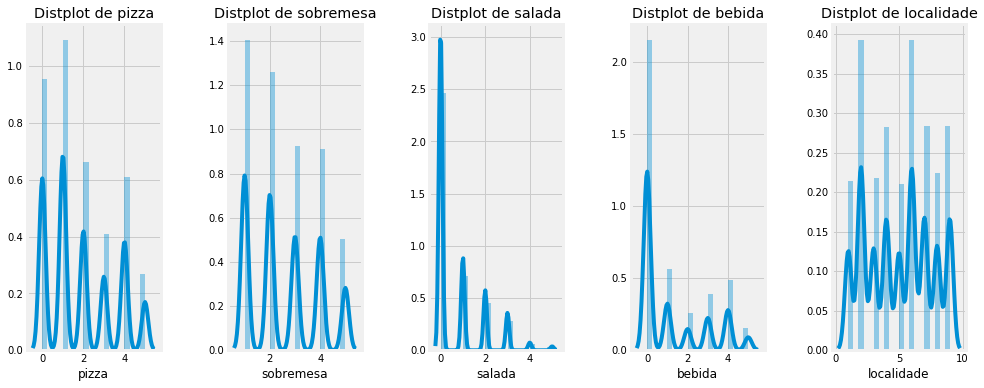

In [21]:
# Distplot dos Atributos Usados Para Segmentação

plt.figure(1, figsize = (15, 6))
n = 0

for x in ['pizza', 'sobremesa', 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1, 5, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(df_item_pedidos[x], bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()

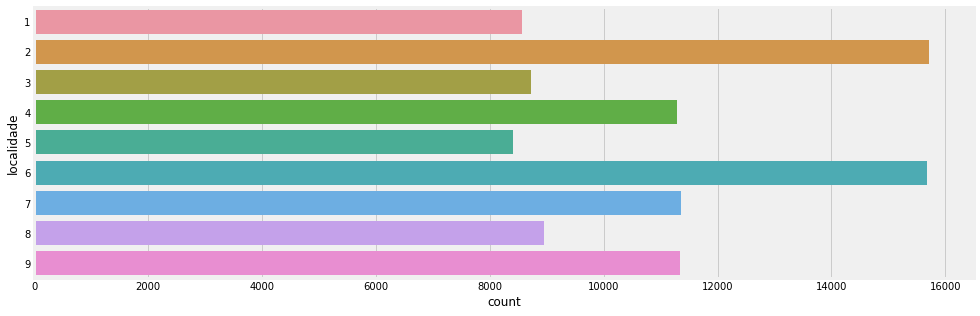

In [22]:
plt.figure(1, figsize = (15, 5))
sns.countplot(y = 'localidade', data = df_item_pedidos)
plt.show()

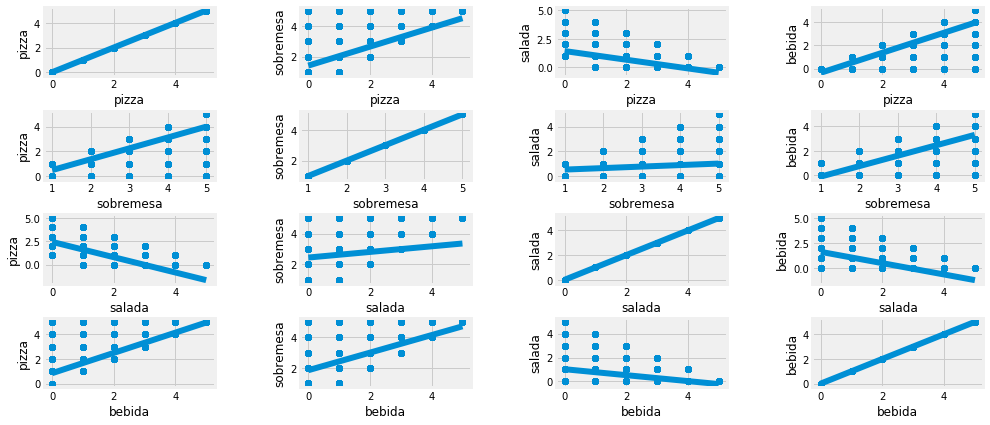

In [23]:
plt.figure(1, figsize = (15, 7))
n = 0

for x in ['pizza', 'sobremesa', 'salada', 'bebida']:
    for y in ['pizza', 'sobremesa', 'salada', 'bebida']:
        n += 1
        plt.subplot(4, 4, n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.regplot(x = x, y = y, data = df_item_pedidos)
        plt.ylabel(y)
plt.show()

### Definindo Variáveis Para Segmentação

In [24]:
df = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

In [25]:
df.head(3)

index  bebida  pizza  sobremesa  salada  localidade
0      0       0      1          1       0           9
1      1       0      2          2       0           6
2      2       4      4          5       1           9

#### Segmentação 1

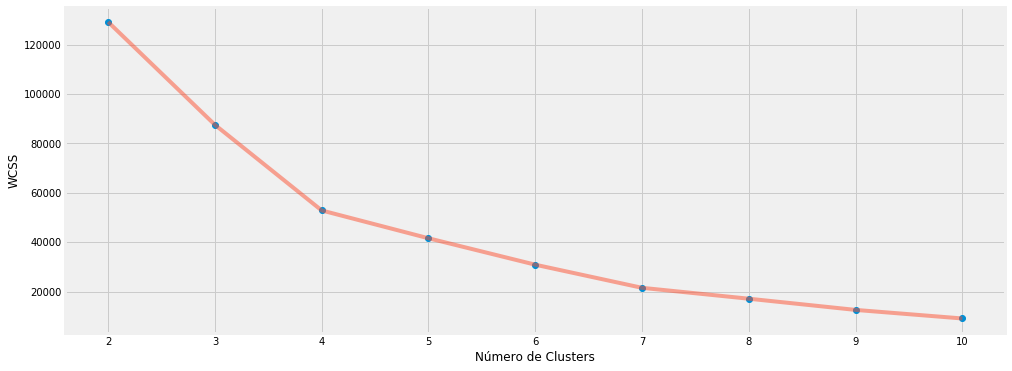

In [26]:
X1 = df[['pizza', 'sobremesa']].iloc[:,:].values
wcss_X1 = []

for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(2, 11), wcss_X1, 'o')
plt.plot(np.arange(2,11), wcss_X1, '-', alpha = 0.5)
plt.xlabel('Número de Clusters'), plt.ylabel('WCSS')
plt.show()

In [27]:
# Criação do Modelo
modelo_seg1 = KMeans(n_clusters = 2,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan')

# Treinamento do Modelo
modelo_seg1.fit(X1)

# Extração dos Labels
labels1 = modelo_seg1.labels_
labels1

# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

array([[0.881644  , 1.82183485],
       [3.79958153, 4.05580631]])

#### Segmentação 1 - Visualização e Interpretação

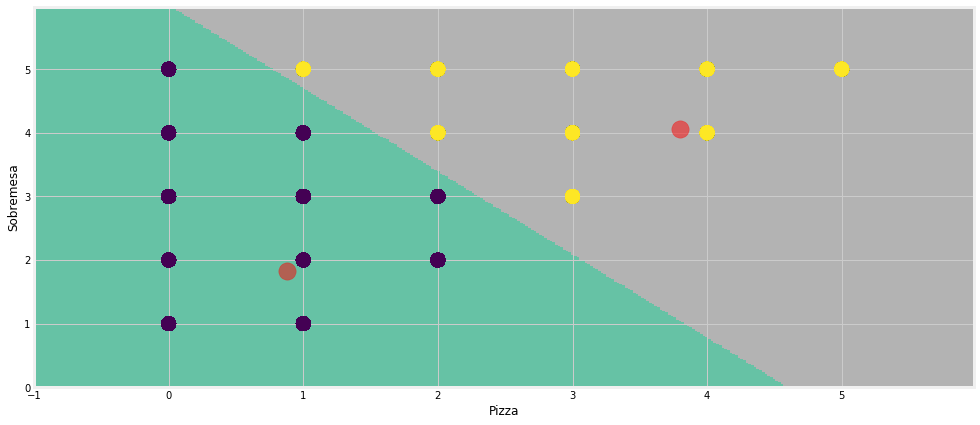

In [28]:
# Plot 

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:,0].min() - 1, X1[:,0].max() + 1
y_min, y_max = X1[:,1].min() - 1, X1[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()])
plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da Imagem
plt.imshow(Z,
          interpolation = 'nearest',
          extent = (xx.min(), xx.max(), yy.min(), yy.max()),
          cmap = plt.cm.Set2,
          aspect = 'auto',
          origin = 'lower')

# Plot dos pontos de dados
plt.scatter(x = 'pizza', y = 'sobremesa', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0], y = centroids1[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

#### Interpretação:

- O ponto vermelho é o centróide de cada cluster (segmento).
- No cluster 1 (área em verde) temos os clientes que pediram 0, 1 ou 2 Pizzas. Em todos os casos houve pedido de Sobremesa.
- No cluster 2 (área em cinza) estão clientes que pediram 2, 3, 4 ou 5 Pizzas. Perceba que à medida que o pedido tem maior número de Pizzas, também aumenta o número de Sobremesas.

#### Análise:

- Cluster 1 - Clientes que pedem menos Pizzas. Todos pedem sobremesa.
- Cluster 2 - Clientes que pedem mais Pizzas. Todos pedem sobremesa em volume maior.

Como estratégia de Marketing, poderíamos oferecer ao cliente uma sobremesa grátis no caso de comprar mais uma Pizza de maior valor. Com base na Segmentação provavelmente essa estratégia teria sucesso.

#### Segmentação 2

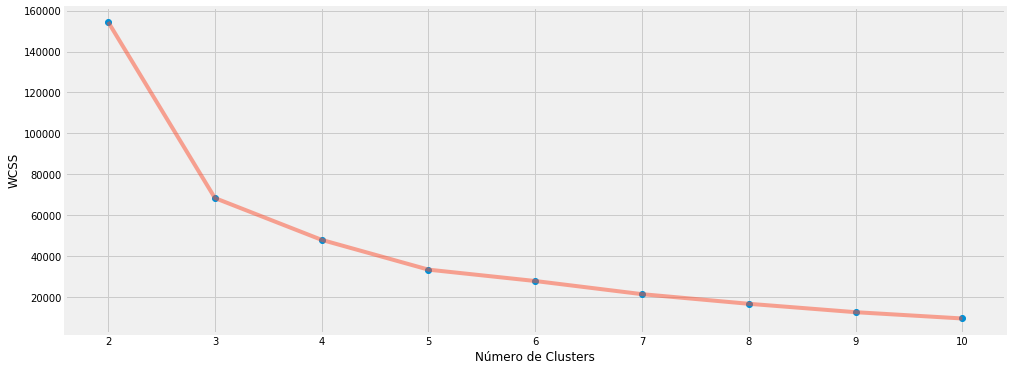

In [29]:
X1 = df[['pizza', 'salada']].iloc[:,:].values
wcss_X1 = []

for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(2, 11), wcss_X1, 'o')
plt.plot(np.arange(2,11), wcss_X1, '-', alpha = 0.5)
plt.xlabel('Número de Clusters'), plt.ylabel('WCSS')
plt.show()

In [30]:
# Criação do Modelo
modelo_seg2 = KMeans(n_clusters = 3,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan')

# treinamento do Modelo
modelo_seg2.fit(X1)

# Extração dos Labels
labels2 = modelo_seg2.labels_

# Extração dos centróides
centroids2 = modelo_seg2.cluster_centers_


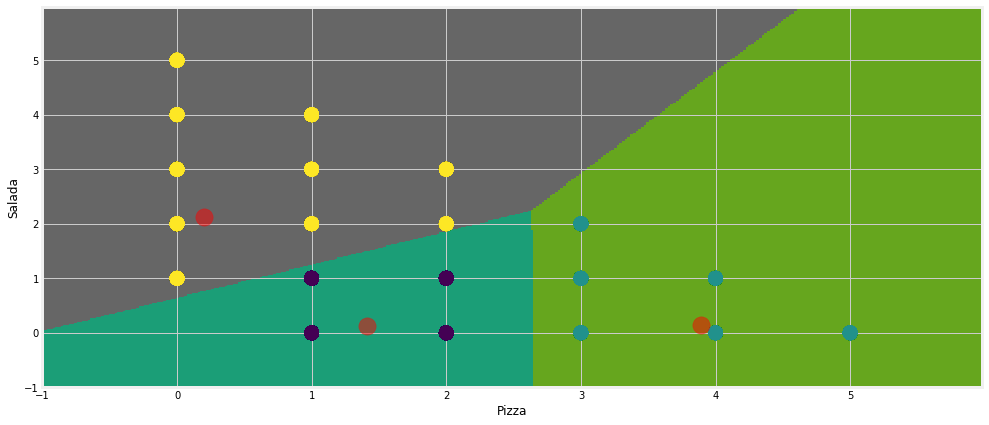

In [31]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg2.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Dark2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'salada', data = df, c = labels2, s = 200 )
plt.scatter(x = centroids2[: , 0], y =  centroids2[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Salada')
plt.show()

#### Interpretação:

- O ponto vermelho é o centróide de cada cluster (segmento).
- No cluster 1 (área em cinza) temos os clientes que pediram menos Pizzas e mais Saladas.
- No cluster 2 (área em verde escuro) temos os clientes que pediram poucas Pizzas e poucas Saladas.
- No cluster 3 (área em verde claro) estão clientes que pediram mais Pizzas e menos Saladas.

#### Análise:

- Os clusters 1 e 3 são de clientes com comportamentos opostos. A equipe de Marketing poderia concentrar os esforços nos clientes do cluster 2, pois são clientes que compram Pizzas e Saladas e, portanto, tendem a consumir mais itens variados evitando manter os estoques cheios de um único item.

- Ou então, concentrar os esforços nos clientes que consomem produtos que geram mais lucro. Teríamos que verificar qual item, Pizza ou Salada, é mais rentável.

#### Segmentação 3

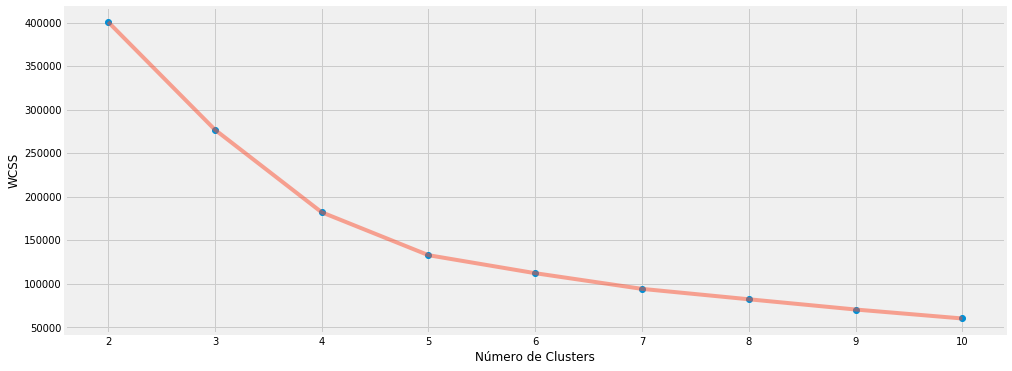

In [32]:
X1 = df[['pizza', 'localidade']].iloc[:,:].values
wcss_X1 = []

for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(2, 11), wcss_X1, 'o')
plt.plot(np.arange(2,11), wcss_X1, '-', alpha = 0.5)
plt.xlabel('Número de Clusters'), plt.ylabel('WCSS')
plt.show()

In [33]:
# Criação do modelo com 4 clusters
modelo_seg3 = KMeans(n_clusters = 4,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan')

# Treinamento do modelo
modelo_seg3.fit(X1)

# Labels
labels3 = modelo_seg3.labels_

# Centróides
centroids3 = modelo_seg3.cluster_centers_

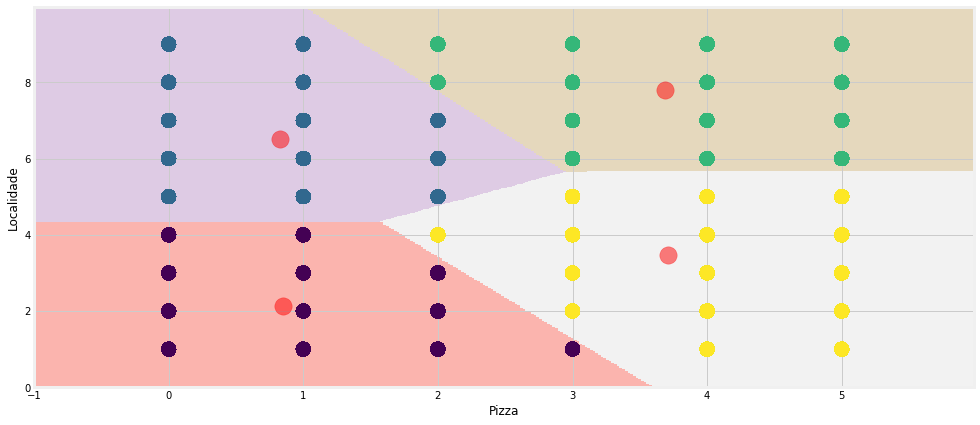

In [34]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg3.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel1, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'localidade', data = df, c = labels3, s = 200 )
plt.scatter(x = centroids3[: , 0], y =  centroids3[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Localidade')
plt.show()

#### Interpretação: 

- O ponto vermelho é o centróide de cada cluster (segmento).
- Os clusters da esquerda no gráfico contém os pedidos de todas as Localidades, mas com menor número de Pizzas. Já os clusters da direita no gráfico contém pedidos de todas as Localidades com com maior número de Pizzas.

#### Análise:

- Teríamos que investigar mais a fundo os pedidos dos clusters à esquerda do gráfico e compreender em mais detalhes as características desses pedidos e que tipo de oferta podemos fazer. Aqui a localidade não seria um fator para segmentação.

#### Segmentação 4

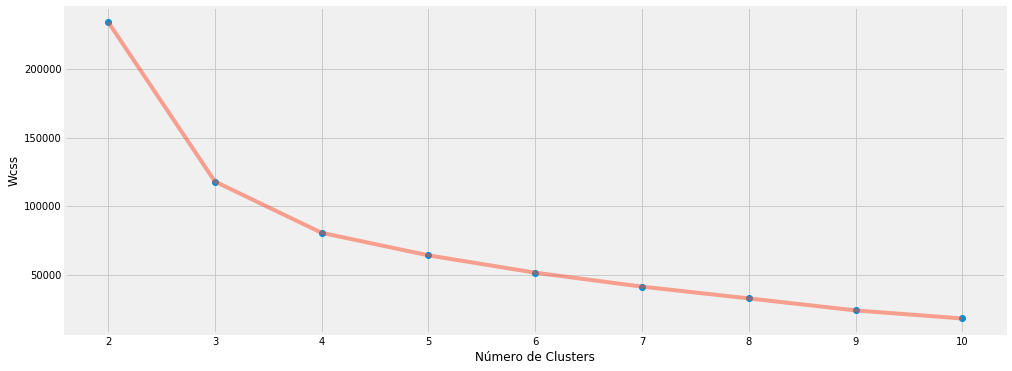

In [35]:
X1 = df[['pizza' , 'salada' , 'sobremesa']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
wcss_X1 = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , wcss_X1 , 'o')
plt.plot(np.arange(2 , 11) , wcss_X1 , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Wcss')
plt.show()

In [36]:
modelo_seg5 = (KMeans(n_clusters = 2,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg5.fit(X1)

# Labels
labels5 = modelo_seg5.labels_

# Centróides
centroids5 = modelo_seg5.cluster_centers_

In [37]:
# Pacotes para o gráfico 3D
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

In [38]:
# Plot

# Gráfico 3D
grafico = go.Scatter3d(x = df['pizza'], 
                       y = df['salada'], 
                       z = df['sobremesa'], 
                       mode = 'markers', 
                       marker = dict(color = labels5, 
                                     size = 4,
                                     line = dict(color = labels5, width = 15),
                                     opacity = 0.7))

# Layout do gráfico
layout = go.Layout(title = 'Clusters',
                   scene = dict(xaxis = dict(title  = 'Pizza'),
                                yaxis = dict(title  = 'Salada'),
                                zaxis = dict(title  = 'Sobremesa')))

# Plot da figura (gráfico + layout)
fig = go.Figure(data = grafico, layout = layout)
py.offline.iplot(fig)

#### Interpretação:

- Observamos a separação entre os dados em dois 2 clusters.
- Todos pedidos tem sobremesa.
- Menos pizza pode ser sinal de mais salada.
- Em quase todos os pedidos a quantidade de sobremesa é igual a soma da quantidade dos outros produtos.

#### Análise

- A segmentação será feita em 2 clusters de acordo com a quantidade de número de pizza por pedido, pelo fato da pizza ser um produto mais rentável que a salada.

In [39]:
labels5.shape

(100000,)

In [40]:
type(labels5)

numpy.ndarray

In [41]:
df_labels = pd.DataFrame(labels5)

In [42]:
df_labels.head()

0
0  1
1  1
2  0
3  1
4  0

In [43]:
df_final = df.merge(df_labels, left_index = True, right_index = True)

In [44]:
df_final.rename(columns = {0: 'cluster'}, inplace = True)

In [45]:
df_final

index  bebida  pizza  sobremesa  salada  localidade  cluster
0          0       0      1          1       0           9        1
1          1       0      2          2       0           6        1
2          2       4      4          5       1           9        0
3          3       0      1          1       0           6        1
4          4       3      3          3       0           2        0
...      ...     ...    ...        ...     ...         ...      ...
99995  99995       4      4          4       0           4        0
99996  99996       0      1          1       0           2        1
99997  99997       1      1          1       0           2        1
99998  99998       0      2          2       0           3        1
99999  99999       0      1          1       0           2        1

[100000 rows x 7 columns]

In [46]:
df_final.to_csv("SegmentacaoFoodDelivery.csv", encoding = 'utf-8')